# Traffic Sign Classifier

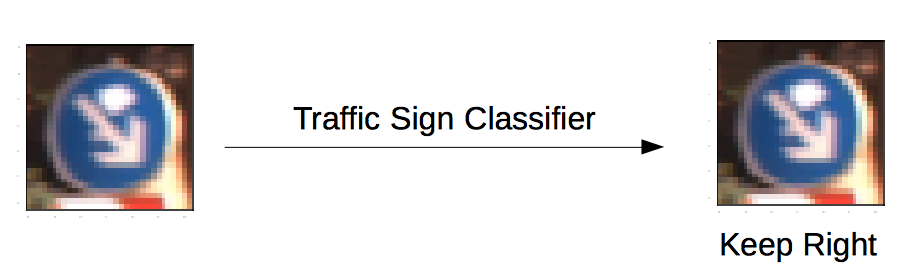

Build a traffic sign classifier using the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=news), deep learning and TensorFlow. To be interesting, besides learning about deep learning and TensorFlow, the classifier should be better than humans at classifying German traffic signs.

---

* [Imports](#a0)
* [Data Set](#a2)
    * [Distribution](#a21)
    * [Visualisation](#a22)
* [Preprocessing](#a3)
    * [Contrast](#a31)
    * [Grayscale](#a32)
    * [Edges Detection](#a33)
    * [Scale](#a34)
    * [Preprocessing](#a35)
* [Model](#a4)
    * [Evaluation](#a41)
    * [Training](#a42)
    * [Test](#a43)

---

## Imports <a class="anchor" id="a0"></a>

In [3]:
import os
import pickle
import csv
import matplotlib.pyplot as plt
import random
import numpy as np
import matplotlib
matplotlib.rcParams['font.size'] = 10
%matplotlib inline
from skimage.filters import gaussian
from skimage.feature import canny
from skimage import img_as_ubyte
from sklearn import preprocessing as skpp
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import re
from scipy import misc
from sklearn.utils import shuffle


## Data Set <a class="anchor" id="a2"></a>

Address where to find the data:

In [9]:
data_dir = os.path.join('.','traffic-signs-data')

Load training, validation, testing data and a dictionnary to have names associated to numerical classes:

In [10]:
def get_and_split(filename):
    with open(os.path.join(data_dir,filename), mode='rb') as f:
        data = pickle.load(f)
    return data['features'], data['labels']


X_train, Y_train = get_and_split('train.p')
X_valid, Y_valid = get_and_split('valid.p')
X_test, Y_test = get_and_split('test.p')

assert len(set(Y_train)) == len(set(Y_valid)) == len(set(Y_test))



def get_sign_names():
    signames_file = os.path.join(data_dir,'signnames.csv')
    with open(signames_file, newline='') as f:
        reader = csv.reader(f)
        next(reader) # skip first line
        signames = {}
        for row in reader:
            signames[int(row[0])] = row[1]
    def sign_names(code):
        return signames[code]

    return sign_names
    
sign_names = get_sign_names()

print("Label 0 means: ", sign_names(0))

Label 0 means:  Speed limit (20km/h)


### Distribution <a class="anchor" id="a21"></a>

In [11]:
print("Image data shape =", X_train[0].shape)
print("Number of training examples =", len(X_train))
print("Number of validation examples =", len(X_valid))
print("Number of testing examples =", len(X_test))
print("Number of classes =", len(set(Y_train)))

Image data shape = (32, 32, 3)
Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Number of classes = 43


Number of examples per classes:

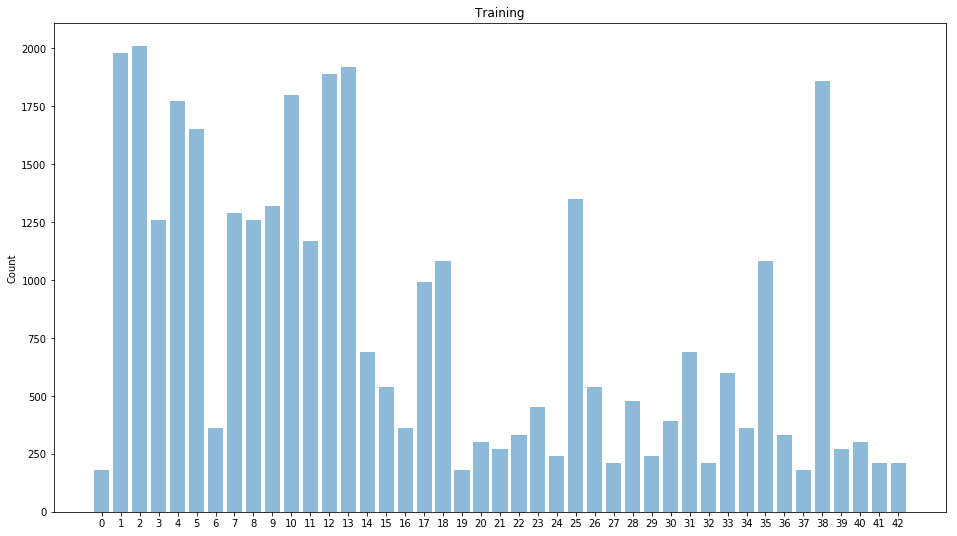

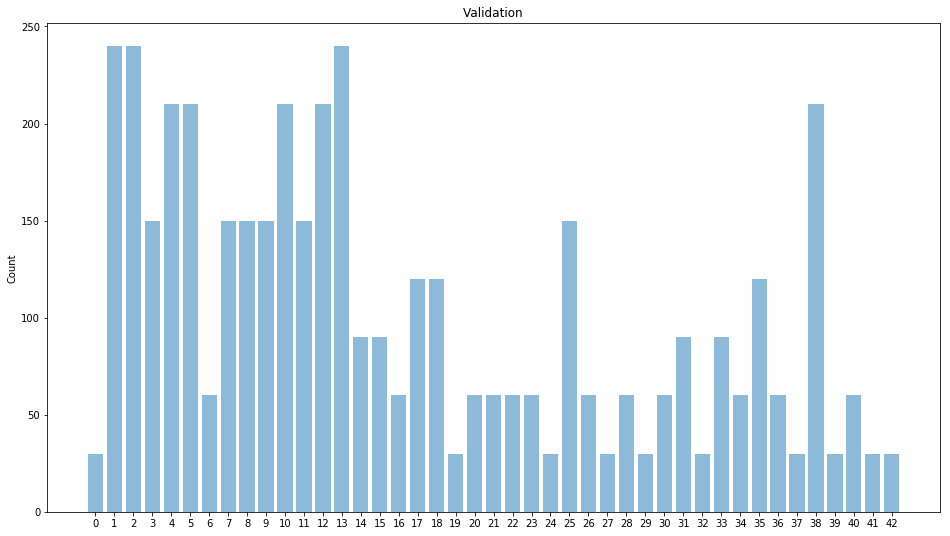

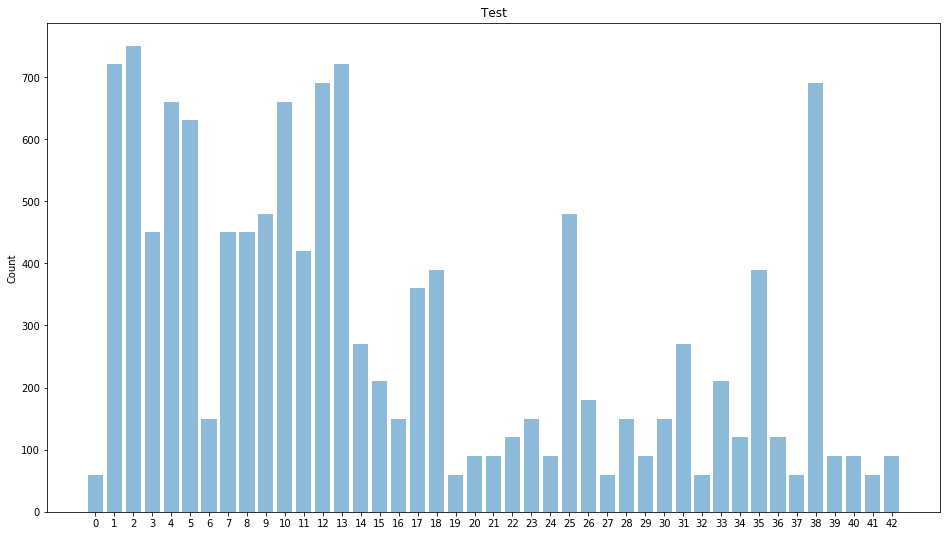

In [12]:
def images_distribution(labels):
    counts = {}
    for label in labels:
        if label in counts:
            counts[label] += 1
        else:
            counts[label] = 1            
    return counts.items()


def plot_images_distribution(dist,title='Title'):
    counts = [count for (label,count) in dist]
    labels = [label for (label,count) in dist]
    plt.figure(figsize=(16,9))
    y_pos = np.arange(len(labels))
    plt.bar(y_pos, counts, align='center', alpha=0.5)
    plt.xticks(y_pos, labels)
    plt.ylabel('Count')
    plt.title(title)
    plt.show()


plot_images_distribution(images_distribution(Y_train), title="Training")
plot_images_distribution(images_distribution(Y_valid), title="Validation")
plot_images_distribution(images_distribution(Y_test), title="Test")

The classifier should be better than humans across all classes. If it is not, it may be because of the uneven dataset across classes. The classifier is a mere reflection of the dataset. A way to correct this defect may be to generate examples for each classes by altering them with noise, rotations, translations, ... as described in [Sermanet Ijcnn 11](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf) so that the resulting distribution is less uneven than the original one and with enough examples per class for the classifier to learn better.

## Visualisation <a class="anchor" id="a22"></a>

Let's draw a couple of these images:

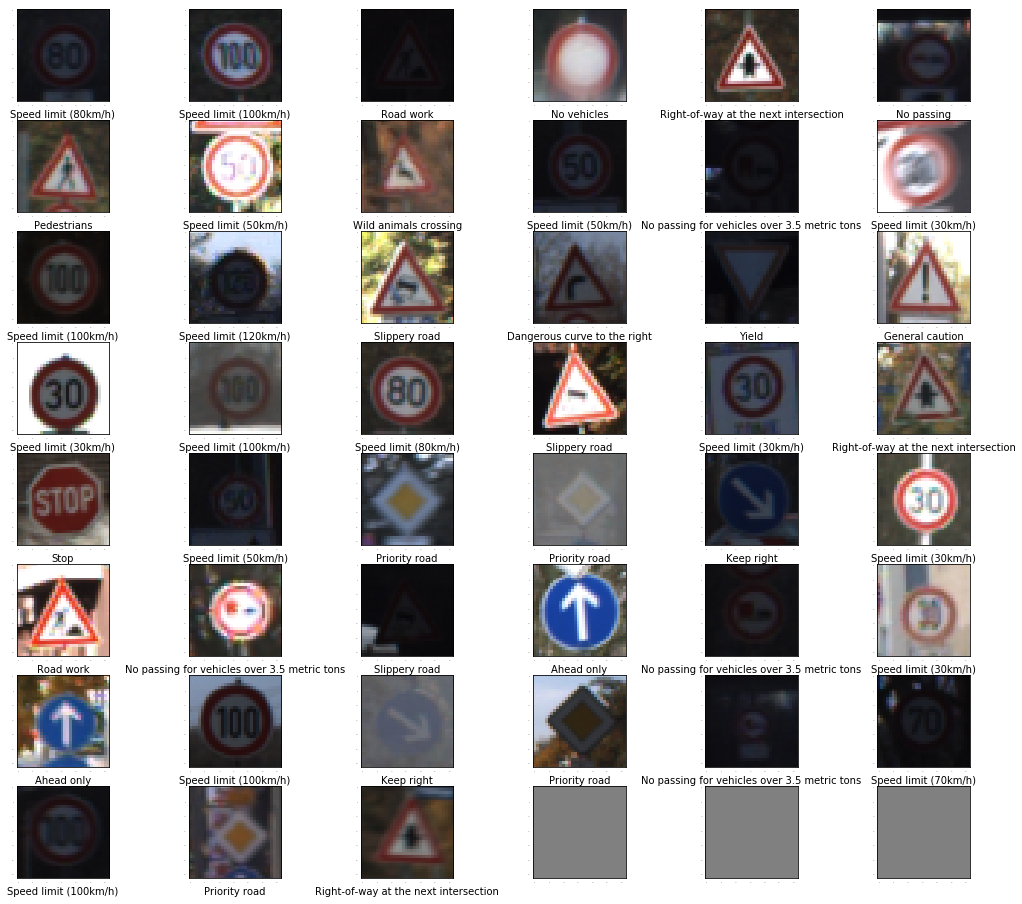

In [13]:
def filler_image(ex_image):
    height,width, *rest = ex_image.shape
    return np.array([[ [128.0,128.0,128.0] for j in range(width)] for i in range(height)])


def graph_images(images,labels=None,cmap=None):
    n_images = len(images)
    ex_image = images[0]
    height,width, *rest = ex_image.shape
    max_width = 6
    grid_width = n_images if n_images < max_width else max_width
    grid_height = 1 + (n_images-1) // max_width
    
    fig = plt.figure(figsize=(3*grid_width,2*grid_height))
    for i in range(grid_height):
        for j in range(grid_width):
            index = i*grid_width + j
            ax = plt.subplot2grid((grid_height, grid_width), (i, j))
            ax.tick_params(length=0.01,labelsize=0.01)
            
            if index < n_images:
                raw_image = np.squeeze(images[index])
                if labels is not None:
                    label = sign_names(labels[index])
                    ax.set_xlabel(label)
            else:
                raw_image = filler_image(ex_image) 
                plt.set_cmap('gray')
            
            if cmap is not None:
                plt.set_cmap(cmap)
            ax.imshow(raw_image,aspect='equal')
            
def draw_random_images(images,labels,nbr):
    random_indexes = [ random.randint(0, len(images)) for x in range(0,nbr)]
    rand_images = np.array([images[idx] for idx in random_indexes])
    rand_labels = np.array([labels[idx] for idx in random_indexes])
    return rand_images,rand_labels,random_indexes
        
rand_images, rand_labels,random_indexes = draw_random_images(X_train,Y_train,45)         
   
graph_images(rand_images,rand_labels)

In all images, the vast majority of pixels are attributed to the signs. It is probably useful to preprocess images to make their contrasts roughly equal so that the network can focus on what matters: the signs, and not the signs in all the different possible contrasts.

## Preprocessing The Data Set <a class="anchor" id="a3"></a>

Let's define a small set of examples so that we can experiment with them efficiently:

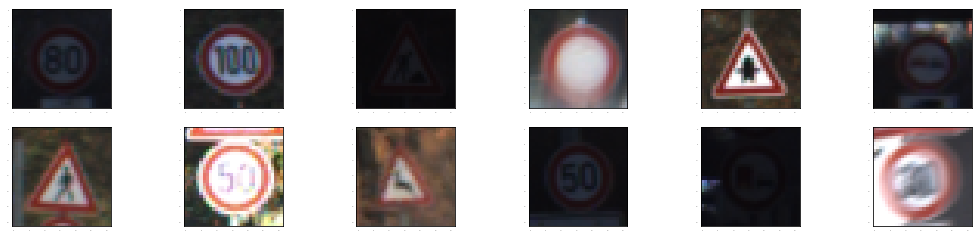

In [14]:
prepro_images = rand_images[0:12]
graph_images(prepro_images)

### Contrast <a class="anchor" id="a31"></a>

Let's equalize images' contrasts without destroying their content:

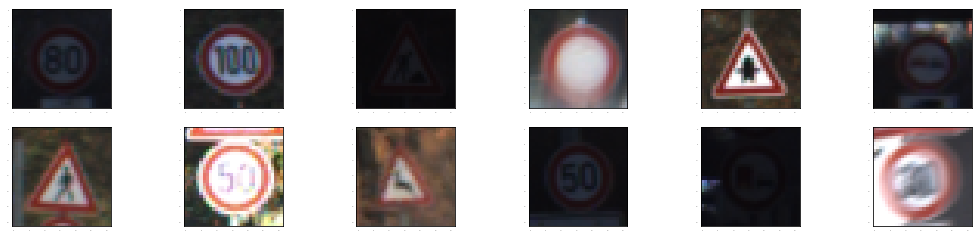

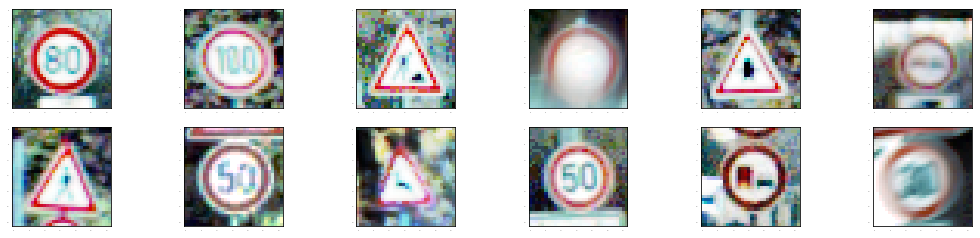

In [15]:
from skimage import exposure

def to_CxHxW(hwc_image):
    if len(hwc_image.shape) == 2:
        rows, cols = hwc_image.shape
        return np.array([[[hwc_image[i][j] for j in range(cols)]
                            for i in range(rows)]]) 
                          
    else:
        rows, cols, chs = hwc_image.shape
        return np.array([[[hwc_image[i][j][c] for j in range(cols)]
                            for i in range(rows)]  
                          for c in range(chs)])

def correct_contrast_cwh(cwh_image):
    chs, rows, cols = cwh_image.shape
    #assert cwh_image.shape == (3,32,32)
    return np.array([exposure.adjust_log(exposure.equalize_hist(cwh_image[c]), 1) 
                     for c in range(chs)])

def to_HxWxC(chw_image):
    chs, rows, cols = chw_image.shape
    return np.array([[[chw_image[c][i][j] for c in range(chs)] 
         for j in range(cols)]
       for i in range(rows)])

def correct_contrast(images):
    #assert hwc_image.shape == (32,32,3)
    return np.array([to_HxWxC(correct_contrast_cwh(to_CxHxW(image))) for image in images])

prepro_images_corrected_contrast = correct_contrast(prepro_images)
graph_images(prepro_images)
graph_images(prepro_images_corrected_contrast)

### Grayscale <a class="anchor" id="a32"></a>

Since the differences between the signs seem to rely essentially on shapes and forms, it's worth trying to grayscale the images because it divides the number of pixels by 3 (1 gray channel instead of 3 RGB channels) and keep what matters: shapes and forms.

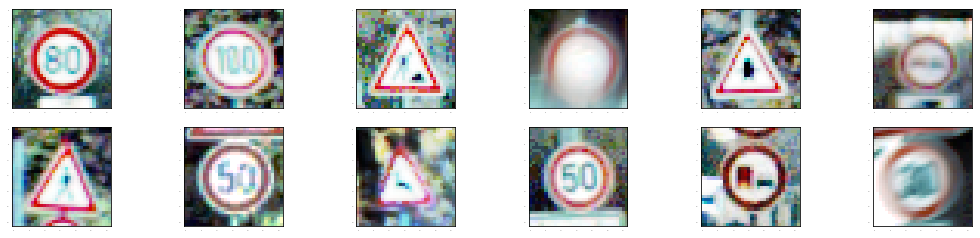

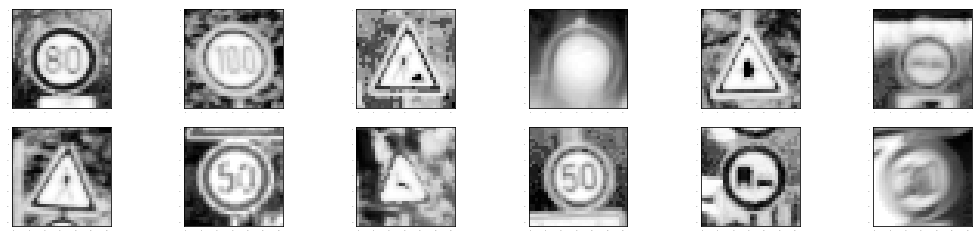

In [16]:
from skimage.color import rgb2gray

def to_grayscale(images):
    return np.array([rgb2gray(image) for image in images])

picc = prepro_images_corrected_contrast
picc_grayscale = to_grayscale(picc)
graph_images(picc)
graph_images(picc_grayscale,cmap='gray')

### Edges detection <a class="anchor" id="a33"></a>

All signs are bounded by a geometrical form: circle, triangle, square... The edge of the bounding form makes a sharp contrast with the background. I thought it might be a good idea to augment the grayscale images with detected edges using the Canny algorithm:

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


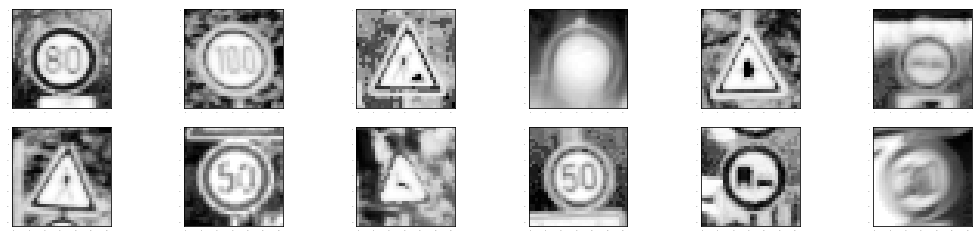

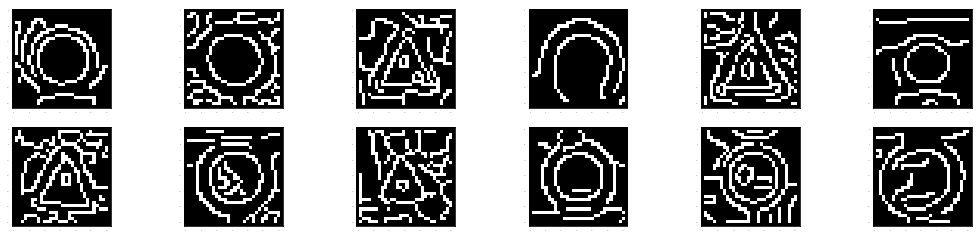

In [17]:
def gaussian_blur(images):
    return np.array([gaussian(image,sigma=0.25) for image in images])

def select_edges(images):
    l_tshd = 255.0*0.3
    h_tshd = 255.0*0.6
    return np.array([canny(img_as_ubyte(image),sigma=1,low_threshold=l_tshd,high_threshold=h_tshd) 
                     for image in images])

piccg = picc_grayscale
piccgg_canny = select_edges(gaussian_blur(piccg))
graph_images(piccg,cmap='gray')
graph_images(piccgg_canny,cmap='gray')

Unfortunatly and after many trial and errors, I did not find a good enough set of parameters. Images are too small maybe? First order derivative eats at least 2x the pixels of no derivative at all.

### Scale <a class="anchor" id="a34"></a>

Finally, we scale the images so that pixels values have zero mean. It makes the optimisation easier and does not subtract information from the images because it is not encoded in their pixels absolute values but the relative differences between pixels, which is preserved by translation:

In [18]:
# image → to_grayscale → correct_contrast → scale → preprocessed image.

def rm_mean(chw_image):
    chs,rows,cols = chw_image.shape
    return np.array([skpp.scale(chw_image[c],with_std=False) for c in range(chs)])

def scale(images):
    return np.array([to_HxWxC(rm_mean(to_CxHxW(image))) for image in images])

### Preprocessing <a class="anchor" id="a35"></a>

Let's preprocess our datasets.  We saved the preprocessing because we decided not to change it after some trial and errors and it takes a while to complete.

In [19]:
def preprocess_images(images):
    return scale(to_grayscale(correct_contrast(images)))

preprocessed_image = preprocess_images(prepro_images[0:1])[0]
print("A preprocessed image mean: ", preprocessed_image.mean())

A preprocessed image mean:  -1.04083408559e-17


In [20]:
#X_train_preprocessed = preprocess_images(X_train)
#X_valid_preprocessed = preprocess_images(X_valid)
#X_test_preprocessed = preprocess_images(X_test)

with open('./X_train_preprocessed_cache-adfa.p','rb') as f:
    X_train_preprocessed = pickle.load(f)
    
with open('./X_valid_preprocessed-adfa.p','rb') as f:
    X_valid_preprocessed = pickle.load(f)

with open('./X_test_preprocessed-adfa.p','rb') as f:
    X_test_preprocessed = pickle.load(f)

#with open('./X_train_preprocessed_cache-adfa.p','wb') as f:
#     pickle.dump(X_train_preprocessed,f)
    
#with open('./X_valid_preprocessed-adfa.p','wb') as f:
#     pickle.dump(X_valid_preprocessed,f)

#with open('./X_test_preprocessed-adfa.p','wb') as f:
#     pickle.dump(X_test_preprocessed,f)

print("X_train_preprocessed shape = ", X_train_preprocessed.shape)
print("X_valid_preprocessed shape = ", X_valid_preprocessed.shape)
print("X_test_preprocessed shape = ", X_test_preprocessed.shape)

X_train_preprocessed shape =  (34799, 32, 32, 1)
X_valid_preprocessed shape =  (4410, 32, 32, 1)
X_test_preprocessed shape =  (12630, 32, 32, 1)


## Model <a class="anchor" id="a4"></a>

The model is essentially LeNet-5 ([LeCun 98](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf)) because it showed to be working on similar objects: digits classification. Instead of digits, we have signs for which I cannot find any good reason why it would not work, *a priori*.  We tried various configurations, including changing activation functions, concatenating layer 1 and layer 2 outputs as described in [Sermanet Ijcnn 11](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf), various learning rates, introducing new layers, etc. Eventually, time ran out and we settled with just LeNet-5 and deeper layers.

In [22]:
MODEL = {
    'chs': 1,
    'depth_1': 24,
    'depth_2': 48,
    'full_1': 360,
    'dropout': 0.5,
    'full_2': 120,
    'out': 43
}

In [25]:
def network(x):    
    # Match scaling above.
    mu = 0
    sigma = 0.1
    
    # Convolutional. Input = 32 x 32 x MODEL['chs'] Output = 28 x 28 x MODEL['depth_1']
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, MODEL['chs'], MODEL['depth_1']), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(MODEL['depth_1']))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28 x 28 x MODEL['depth_1'] Output = 14 x 14 x MODEL['depth_1']
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Convolutional. Input = 14 x 14 x MODEL['depth_1'] Output = 10x10x MODEL['depth_2']
    conv2_depth = 48    
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, MODEL['depth_1'], MODEL['depth_2']), 
                                              mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(MODEL['depth_2']))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x MODEL['depth_2']. Output = 5x5x MODEL['depth_2'].
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Flatten. Input = 5x5x MODEL['depth_2']. Output = 5*5*MODEL['depth_2']
    fc0   = flatten(conv2)
    fc0_length = 5*5*MODEL['depth_2']
    
    # Fully Connected. Input = fc0_length. Output = full1_out.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(fc0_length,  MODEL['full_1']), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(MODEL['full_1']))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    
    # Dropout.
    fc1 = tf.nn.dropout(fc1, MODEL['dropout'])

    # Fully Connected. Input = full1_out. Output = full2_out.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(MODEL['full_1'], MODEL['full_2']), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(MODEL['full_2']))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    # Fully Connected. Input = MODEL['full_2']. Output = MODEL['out'].
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(MODEL['full_2'], MODEL['out']), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(MODEL['out']))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Evaluation <a class="anchor" id="a41"></a>

Since we only have 43 classes, we go for one hot encoding: 

In [23]:
x = tf.placeholder(tf.float32, (None, 32, 32, MODEL['chs']))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, len(set(Y_test)))

At the output of the model, the mean of the cross entropy over the softmax of the logits gives the model loss function:

In [26]:
logits = network(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)

`evaluate` gives the ratio of correct predictions of the model over the number of predictions:

In [27]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y })
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Training <a class="anchor" id="a42"></a>

[Kingma et al., 2014 Trial](https://arxiv.org/abs/1412.6980) make it clear that Adam algorithm is targeted at stochastic gradient-based optimization within conditions that match ours. It also compares favorably to other algorithms available in TensorFlow. Considering our timing window, there is no point into searching further. Trial and error gave us the learning rate and epsilon. 

In [28]:
optimizer = tf.train.AdamOptimizer(learning_rate = 0.001,epsilon=0.0000000001)
training_operation = optimizer.minimize(loss_operation)

We end up with a 0.940 accuracy on the validation set:

In [19]:
EPOCHS = 20
BATCH_SIZE = 256
optimized_parameters_file = './network_parameters-XXX'
saver = tf.train.Saver()

def train(images_train, labels_train, images_valid, labels_valid):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        num_examples = len(images_train)

        print("Training...")
        print()
        for i in range(EPOCHS):
            images_train, labels_train = shuffle(images_train, labels_train)
            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = images_train[offset:end], labels_train[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})

            validation_accuracy = evaluate(images_valid, labels_valid)
            print("EPOCH {} ...".format(i+1))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))
            print()

        saver.save(sess, optimized_parameters_file)
        print("Model saved")
        
train(X_train_preprocessed, Y_train, X_valid_preprocessed, Y_valid)

Training...

EPOCH 1 ...
Validation Accuracy = 0.725

EPOCH 2 ...
Validation Accuracy = 0.820

EPOCH 3 ...
Validation Accuracy = 0.863

EPOCH 4 ...
Validation Accuracy = 0.888

EPOCH 5 ...
Validation Accuracy = 0.902

EPOCH 6 ...
Validation Accuracy = 0.910

EPOCH 7 ...
Validation Accuracy = 0.915

EPOCH 8 ...
Validation Accuracy = 0.912

EPOCH 9 ...
Validation Accuracy = 0.920

EPOCH 10 ...
Validation Accuracy = 0.928

EPOCH 11 ...
Validation Accuracy = 0.926

EPOCH 12 ...
Validation Accuracy = 0.932

EPOCH 13 ...
Validation Accuracy = 0.925

EPOCH 14 ...
Validation Accuracy = 0.925

EPOCH 15 ...
Validation Accuracy = 0.932

EPOCH 16 ...
Validation Accuracy = 0.936

EPOCH 17 ...
Validation Accuracy = 0.941

EPOCH 18 ...
Validation Accuracy = 0.932

EPOCH 19 ...
Validation Accuracy = 0.939

EPOCH 20 ...
Validation Accuracy = 0.940

Model saved


---

### Test <a class="anchor" id="a43"></a>

To test our newly trained shiny and promising model, we took a couple of images of German traffic signs outside of the data set. Let's see if the model can make predictions.

Here is where the data is located:

In [29]:
web_traffic_signs_dir = os.path.join('.','traffic_signs_from_web')

Load the data:

In [30]:
def get_and_split_web_traffic_signs():
    filenames = [filename 
                 for filename in os.listdir(web_traffic_signs_dir) 
                 if re.search('\.jpg$', filename)]
    
    images = np.array([misc.imread(os.path.join(web_traffic_signs_dir,filename)) for filename in filenames])              
    labels = np.array([int(int_str) for int_str in
                        [os.path.splitext(filename)[0] for filename in filenames] ])
    return images, labels

X_web_test, Y_web_test = get_and_split_web_traffic_signs()

print("Image data shape =", X_web_test[0].shape)
print("Number of training examples =", len(X_web_test))
print("Number of classes =", len(set(Y_web_test)))

Image data shape = (32, 32, 3)
Number of training examples = 6
Number of classes = 6


Let's have a look:

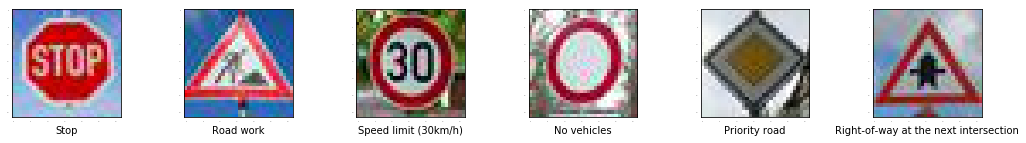

In [31]:
graph_images(X_web_test, Y_web_test)

The images are pretty clean: no crazy contrast, overlapping environment, etc. Supposed to be easy. Let's see what they look like after preprocessing:

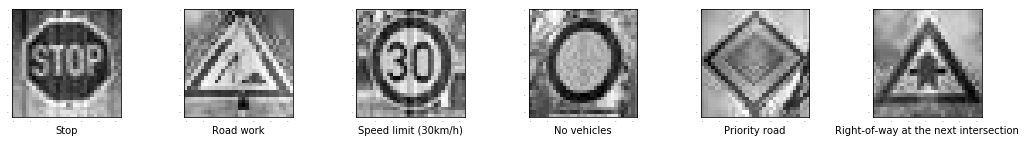

In [32]:
X_web_test_preprocessed = preprocess_images(X_web_test)

graph_images(X_web_test_preprocessed, Y_web_test)

Let's load the parameters of the network we just trained:

In [33]:
parameters = './network_parameters-XXX'

Let's predict the labels:

In [34]:
def predict(images):
    tf.reset_default_graph()
    x = tf.placeholder(tf.float32, (None, 32, 32, MODEL['chs']))
    logits = network(x)
    believes = tf.nn.softmax(logits)
    prediction = tf.argmax(believes,axis = 1)
    saver = tf.train.Saver()
    with tf.Session() as sess:
        saver.restore(sess, parameters)
        return sess.run(prediction, feed_dict={x: images}), sess.run(believes, feed_dict={x: images})
    
Y_web_test_predicted, probabilities = predict(X_web_test_preprocessed)


For each image, we graph the believes of the network concerning its belonging to any class:

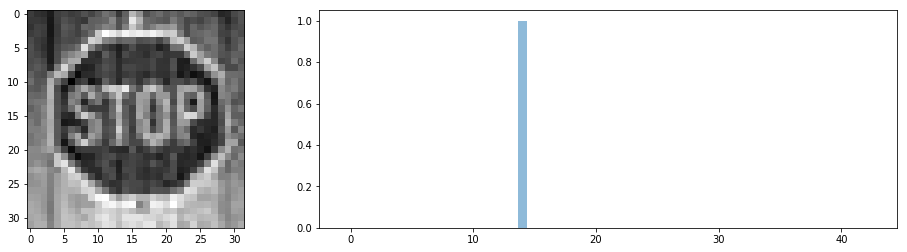

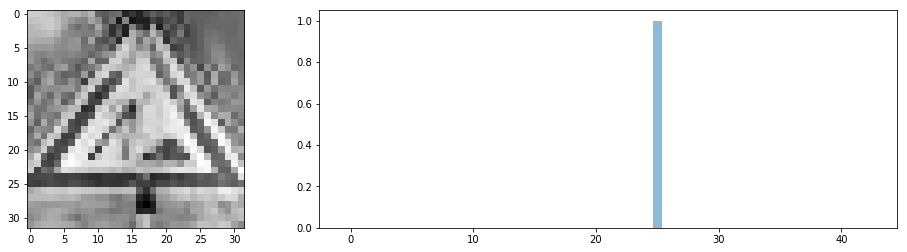

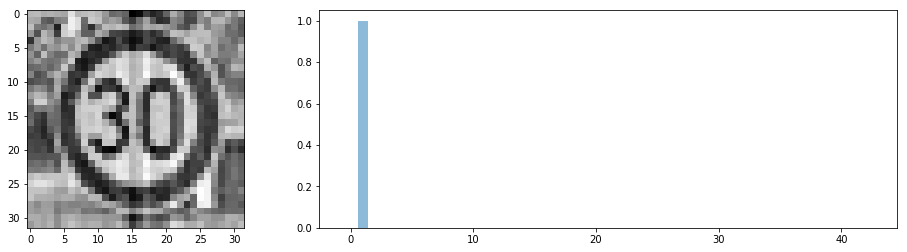

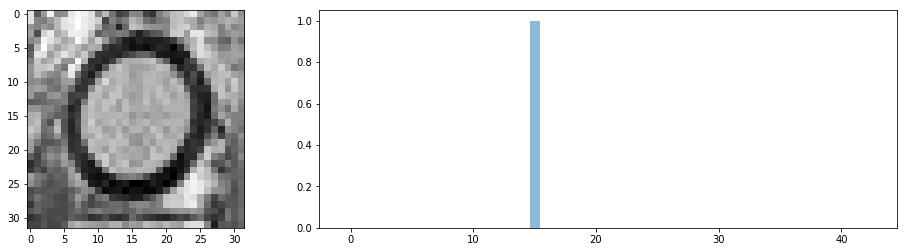

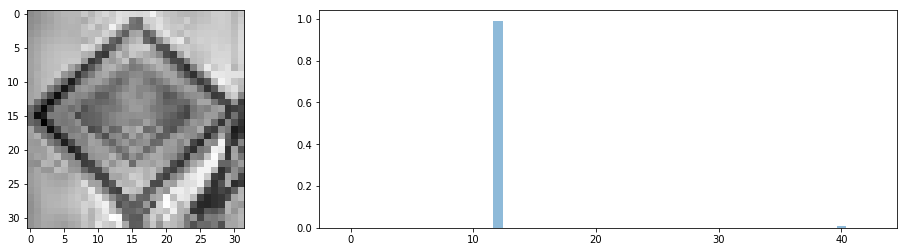

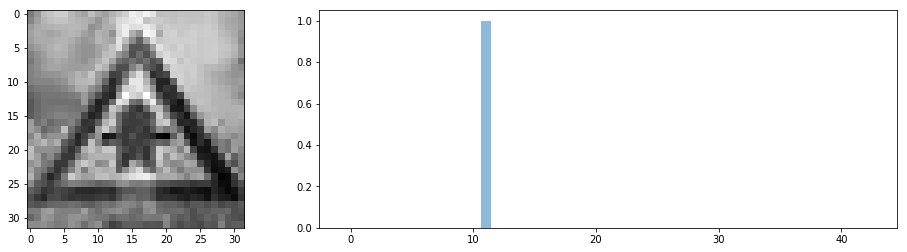

XXXXXX
X Accurracy:  83.33333333333333 %
XXXXXX


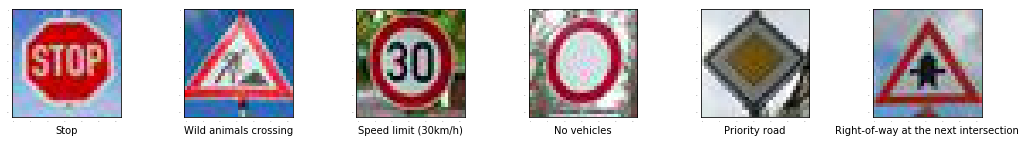

In [35]:
def graph_image_prob(image,probabilities):
    plt.figure(figsize=(16,4))
    ax1 = plt.subplot2grid((1, 3), (0, 0),colspan=1)
    ax1.imshow(np.squeeze(image),aspect='equal')
    ax2 = plt.subplot2grid((1, 3), (0, 1),colspan=2)
    dist = [(i,probabilities[i]) for i in range(len(probabilities))]
    counts = [count for (label,count) in dist]
    labels = [label for (label,count) in dist]
    y_pos = np.arange(len(labels))
    ax2.bar(y_pos, counts, align='center', alpha=0.5)
    plt.show()

for (image,image_probabilities) in zip(X_web_test_preprocessed,probabilities):
    graph_image_prob(image,image_probabilities)
    
def accuracy(expected_labels, predicted_labels):
    assert len(expected_labels) == len(predicted_labels)
    n_success = sum([1 if expected == predicted else 0 
                     for (expected,predicted) in zip(Y_web_test,Y_web_test_predicted)])
    print("XXXXXX")
    print("X Accurracy: ", n_success*100/len(predicted_labels), "%")
    print("XXXXXX")


graph_images(X_web_test, Y_web_test_predicted)
accuracy(Y_web_test, Y_web_test_predicted)

Apparently, the model only has problems with wild animals crossing! Or it was too easy. Let's test it on the testing set:

In [37]:
Y_test_predicted, probabilities = predict(X_test_preprocessed)
accuracy(Y_test, Y_test_predicted)

XXXXXX
X Accurracy:  0.0395882818685669 %
XXXXXX


With about 0.04% accuracy on the testing set, it's safe to say that the model overfits quite a bit. Let's add some dropout to the model and see if it gets better.  Hum. It does not! We should go back at the preprocessing stage and work our data set for a more even distribution.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [28]:
### Print out the top five softmax probabilities from web signs.

def believes(images):
    tf.reset_default_graph()
    x = tf.placeholder(tf.float32, (None, 32, 32, MODEL['chs']))
    keep_prob = tf.placeholder(tf.float32) 
    logits = network(x)
    believes = tf.nn.softmax(logits)
    top_5_believes = tf.nn.top_k(believes,k=5)
    saver = tf.train.Saver()
    with tf.Session() as sess:
        saver.restore(sess, parameters)
        return sess.run(top_5_believes, feed_dict={x: images})
    
top_5 = believes(X_web_test_preprocessed)
print(top_5)

TopKV2(values=array([[  1.00000000e+00,   2.90897750e-09,   2.90348967e-09,
          7.25891125e-10,   1.70254172e-10],
       [  5.58391035e-01,   4.40189987e-01,   1.37742097e-03,
          3.35303230e-05,   6.56194197e-06],
       [  9.99998093e-01,   1.85196984e-06,   1.72201600e-10,
          5.78671497e-13,   3.87499413e-14],
       [  1.00000000e+00,   4.18938884e-10,   7.85384188e-11,
          3.06282018e-13,   2.10008165e-14],
       [  9.99721467e-01,   2.78145395e-04,   2.54071040e-07,
          6.49351151e-08,   1.41360248e-08],
       [  9.99999404e-01,   4.52303624e-07,   1.77717538e-07,
          1.60054248e-10,   5.35688117e-12]], dtype=float32), indices=array([[14, 39,  5, 15, 35],
       [25, 18, 31, 24, 21],
       [ 1,  2,  5,  0,  4],
       [15, 38,  9, 14, 39],
       [12, 40, 35, 38, 13],
       [11, 21, 30, 42, 40]], dtype=int32))
